In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from anticor_features.anticor_features import get_anti_cor_genes
import topo as tp
from topo.tpgraph.intrinsic_dim import IntrinsicDim

In [ ]:
import datetime
print(datetime.datetime.now())

2025-02-28 12:46:33.113052


In [ ]:
raw = sc.read_h5ad('data/earthworm/earthworm.h5ad')
metadata = pd.read_csv('./data/earthworm/Earthworm_sFig4_cell_Info.txt', sep='\t', index_col=0)
adata = raw[metadata.index].copy()
adata.obs = metadata
adata.raw.var.columns = ['features']

In [ ]:
adata.var

,features
evm.TU.Chr01.1000,evm.TU.Chr01.1000
evm.TU.Chr01.1001,evm.TU.Chr01.1001
evm.TU.Chr01.1002,evm.TU.Chr01.1002
evm.TU.Chr01.1004,evm.TU.Chr01.1004
evm.TU.Chr01.1005,evm.TU.Chr01.1005
...,...
evm.TU.ctg2825.1,evm.TU.ctg2825.1
evm.TU.ctg4283.1,evm.TU.ctg4283.1
evm.TU.ctg4583.1,evm.TU.ctg4583.1
evm.TU.ctg5271.2,evm.TU.ctg5271.2


In [ ]:
adata.write_h5ad('./data/earthworm/starterpack/earthworm.h5ad')

In [ ]:
# PFlogPF normalisation
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.normalize_total(adata)

In [ ]:
adata

AnnData object with n_obs × n_vars = 29609 × 29972
    obs: 'Cluster', 'Celltype', 'Stage'
    var: 'features'
    uns: 'log1p'

In [ ]:
anti_cor_table = get_anti_cor_genes(adata.X.T,
                                    adata.var.index.tolist(),
                                    species="",
                                    pre_remove_pathways=[])

selected_table = anti_cor_table[anti_cor_table["selected"]==True]

found 793.28950272 free Gb in /var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T
get_all_remove_genes
29609 1480
min_express_n 50
get_n_expressed
pre_remove_feature: 0
pre_remove_pathway: 0
pre_remove_low_express: 20361
20361  genes to remove out of  29972
rewriting the filtered dataset
/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/exprs.hdf5
total_vars: 9611
making the hdf5 spearman output file
/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/spearman.hdf5
get_the_spears
total_vars 9611
	getting spearman correlation


/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


empirically determined Cneg cutoff: -0.014119913861830083  for FPR of: 0.001
empirically determined Cpos cutoff: 0.03801181648176042  for FPR of: 0.001
get_real_spear
[0, 5000, 9611]
working on 0 5000 vs 5000 9611
	getting spearman correlation


/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/anticor_features/anticor_features.py:402: RuntimeWarning: divide by zero encountered in double_scalars
  FDR_vect[i] = FP_hat_vect[i]/all_sig_neg_vect[i]


In [ ]:
adata.var = pd.concat([adata.var, anti_cor_table], axis=1)

# do some patching to the anti-correlated genes table
adata.var["highly_variable"] = adata.var["selected"].fillna(False)
adata.raw = adata

/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/ipykernel_69807/2695319484.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.var["highly_variable"] = adata.var["selected"].fillna(False)


In [ ]:
adata.uns["proposed_dimensionality"] = 15

sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, n_neighbors=20, use_rep="X_pca", metric="cosine", n_pcs=adata.uns["proposed_dimensionality"])
sc.tl.umap(adata, min_dist=0.1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


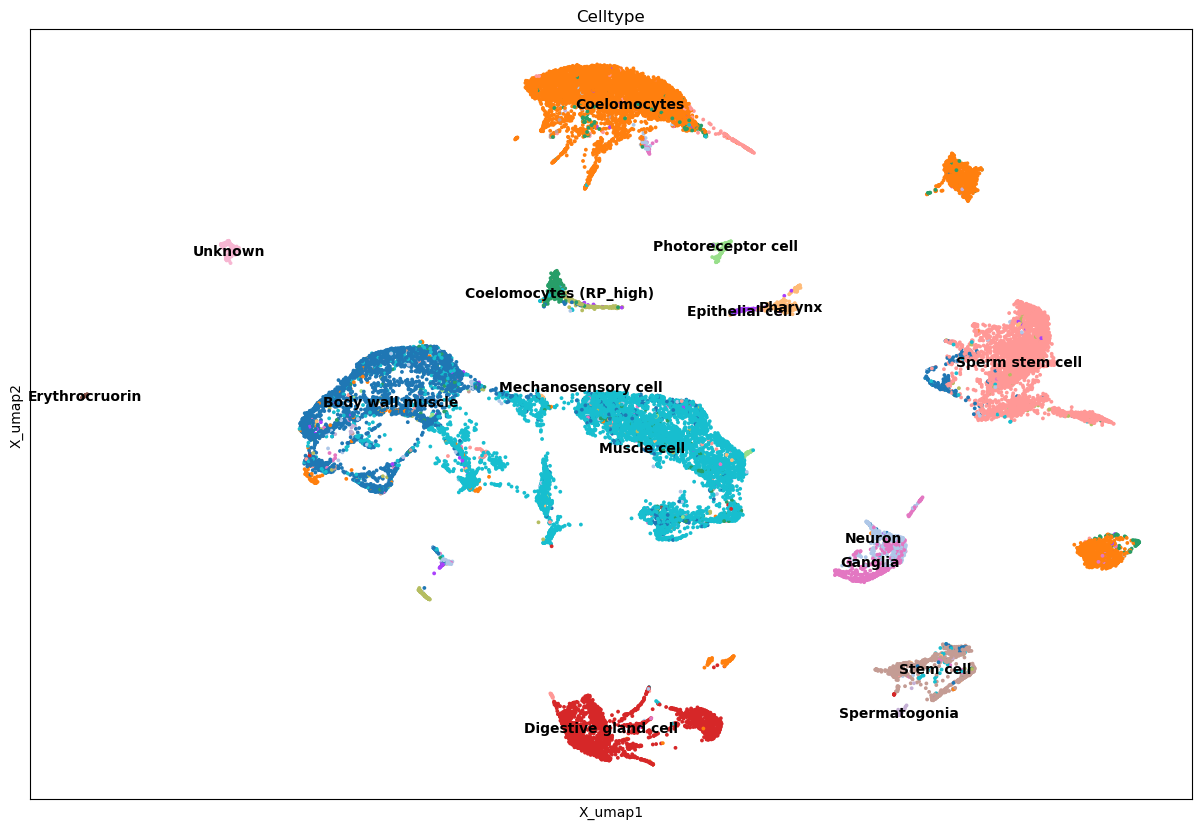

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sc.pl.embedding(adata, basis="X_umap", color="Celltype", legend_loc="on data", ax=ax, s=30)